# Fine-Tuning BERT

This exercise will guide you through the process of using HuggingFace libraries to fine-tune a BERT model.

# Installing the Dependencies

We will need HuggingFace libraries for this task. We will specifically install the [datasets](https://huggingface.co/docs/datasets/en/index), [transformers](https://huggingface.co/docs/transformers/en/index), and [accelerate](https://huggingface.co/docs/accelerate/en/index). Look them up in the links to get more information about each library.  

Speaking broadly, transformers allows us to load and use miriad of models and architectures. It also provides a very convenient trainer class that can train transformers. Datasets provides access to thousands of datasets hosted at HugginFace and more. Accelerate is a library that allows distributed training of PyTorch models. We won't do that, but it is necessary as transformer trainer depends on it.

In [1]:
%%capture
!pip install transformers datasets accelerate scikit-learn -U

# Part 1: Getting The Data

We first get the emotion dataset from HF. Here is the link to the specific dataset: [Emotion Dataset](https://huggingface.co/datasets/dair-ai/emotion). HF gives us a very convenient dataset viewer interface, so we can inspec the dataset to some degree before downloading it.

Step 1: Use HF datasets library to load the dataset

In [1]:
from datasets import load_dataset

# YOUR CODE GOES HERE
emotions = load_dataset("emotion")

print(emotions)

/opt/anaconda3/envs/GenAI/lib/python3.11/site-packages/datasets/load.py:1461: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


Step 2: Access the train split of the dataset.  

Each emotion has a corresponding id for a label. Create two mapping dictionaries, id to label and label to id. Then, print the first 5 sentences alongside their emotion (as a text and as an id). Additionally, get the number of labels and assign it to *num_labels* variable.

Note: These dictionaries and num_labels will be required for exploration and training

In [2]:
num_labels = None

# YOUR CODE GOES HERE
train_ds = emotions["train"]
id2label = {idx: label for idx, label in enumerate(train_ds.features["label"].names)}
label2id = {label: idx for idx, label in id2label.items()}
num_labels = len(id2label)

for i in range(5):
    print(f"Sentence: {train_ds['text'][i]}")
    print(f"Emotion (ID): {train_ds['label'][i]}")
    print(f"Emotion (Text): {id2label[train_ds['label'][i]]}\n")

print(f"Number of Labels: {num_labels}")
print(train_ds["text"][:5], train_ds["label"][:5], [id2label[idx] for idx in train_ds["label"][:5]])

Sentence: i didnt feel humiliated
Emotion (ID): 0
Emotion (Text): sadness

Sentence: i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
Emotion (ID): 0
Emotion (Text): sadness

Sentence: im grabbing a minute to post i feel greedy wrong
Emotion (ID): 3
Emotion (Text): anger

Sentence: i am ever feeling nostalgic about the fireplace i will know that it is still on the property
Emotion (ID): 2
Emotion (Text): love

Sentence: i am feeling grouchy
Emotion (ID): 3
Emotion (Text): anger

Number of Labels: 6
['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'] [0, 0, 3, 2, 3] ['sadness', 'sadness', 'anger', 'love', 'anger']


# Part 2: Exploration

In this part, you will conduct some explorations on the dataset. Exploring the data and spending time looking through examples is a crucial part of training successful ML models. Some of the things you explore here can help make decisions about modeling.

Step 1: Convert the train set from HF dataset into pandas for ease of exploratory analysis

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# YOUR CODE GOES HERE
df = train_ds.to_pandas()

df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


Step 2: Plot the distribution of labels in the dataset. What do you observe?

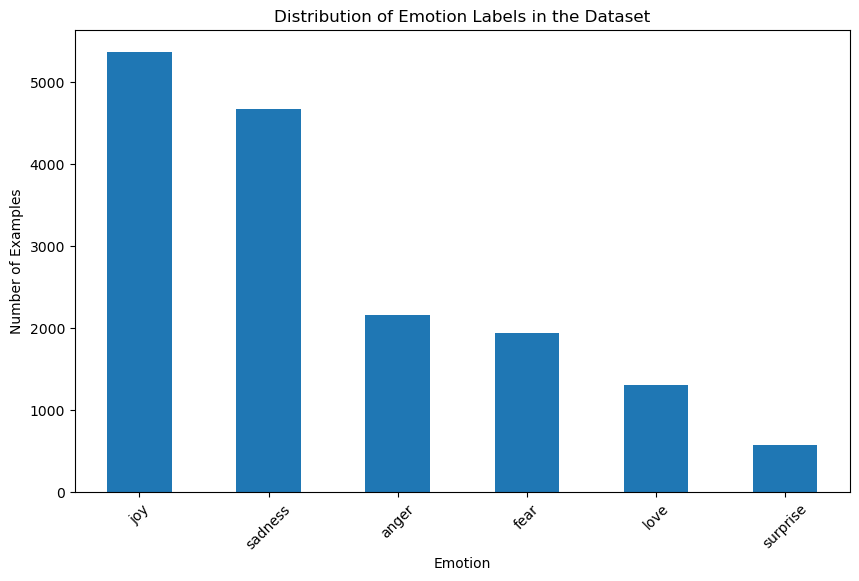

In [4]:
# YOUR CODE GOES HERE

df['label_text'] = df['label'].map(id2label)
label_counts = df['label_text'].value_counts()

plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Emotion Labels in the Dataset')
plt.xlabel('Emotion')
plt.ylabel('Number of Examples')
plt.xticks(rotation=45)
plt.show()

Step 3: Plot the distribution of number of words in the sentences

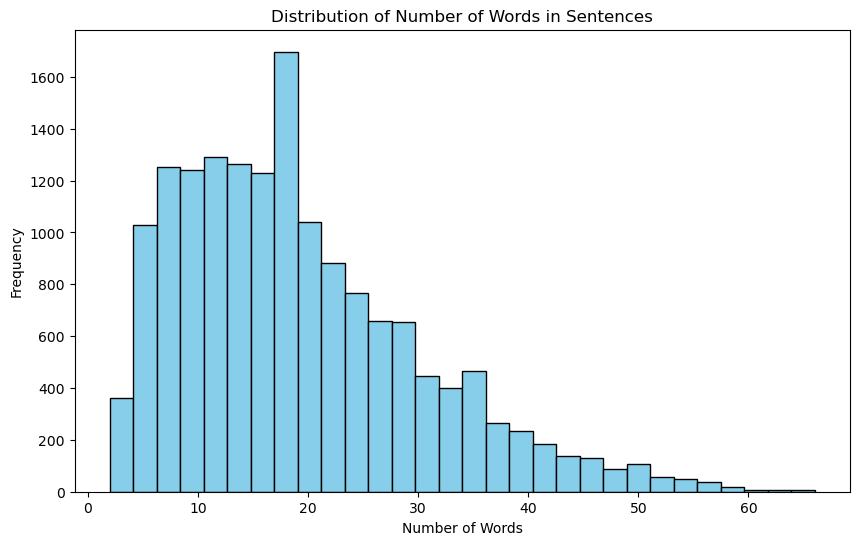

In [5]:
# YOUR CODE GOES HERE

df['word_count'] = df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Number of Words in Sentences')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

## Part 3: Tokenization

As the transformer works with tokenized inputs, you will write a function to tokenize sentences and analyze the results

Step 1: Load the BERT tokenizer from HF. Access and print all the special tokens and their corresponding token ids. The name of the checkpoint is provided.

Alternatively, you may use [DistilBERT](https://arxiv.org/pdf/1910.01108.pdf)

DistilBERT is a distilled version of BERT. It has 40% fewer parameters, is about 60% faster but retains almost full capabilities of the larger BERT model. As a result, it is much faster and easier to fine-tune on low-end devices.  

DistilBERT was achieved by the HuggingFace team by applying knowledge-distillation. Essentially, the knowledge of the teacher BERT was transferred to this smaller student DistilBERT. You can think about the process as some kind of mimicry, where the student model is taught to produce the same output as the teacher model. So, the targets for the student model are the outputs of the teacher model. First, the teacher (BERT) is run on many sentences to produce target logits for the student. Then, the student model is trained on the same sentences to produce the same logits. Thus, a smaller model that performs similarly to the large model can be achieved.

You are encouraged to read more about the process in the DistilBERT paper linked above.

For those who are curious, you can train both models and compare their speed and accuracy.

In [6]:
from transformers import AutoTokenizer, DataCollatorWithPadding
model_ckpt = "bert-base-uncased" # The model that we will fine tune.
# model_ckpt = "distilbert-base-uncased" # distilbert checkpoint.

# YOUR CODE GOES HERE
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


print(tokenizer.all_special_tokens, tokenizer.all_special_ids)

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]'] [100, 102, 0, 101, 103]


Step 2: Tokenize a single sentence from the dataset. Call the tokenizer in a way to obtain both input tokend ids and the attention mask.

In [7]:
tokenized_sentence = None

# YOUR CODE GOES HERE
sentence = train_ds['text'][0]
tokenized_sentence = tokenizer(sentence, padding=True, truncation=True)


tokenized_sentence

{'input_ids': [101, 1045, 2134, 2102, 2514, 26608, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

Step 3: Write a function to tokenize sentences in a batch the same way as above. Make sure to truncate long sequences.

In [8]:
def tokenize(batch):
    """
    batch is a chunk from the dataset which has text and label fields on it
    """
    # YOUR CODE GOES HERE
    return tokenizer(batch['text'], padding=False, truncation=True)


# This data collator will take the batches of sentences, tokenize them and pad to the longest sample in the given batch.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [9]:
tokenized_batch = tokenize(emotions["train"][:2])

assert "attention_mask" in tokenized_batch
assert "input_ids" in tokenized_batch

print(tokenized_batch)

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


Step 4: Use the function you have just written to tokenize sentences in the HF dataset. Assign the result to *emotions_encoded* variable

In [10]:
emotions_encoded = None

# YOUR CODE GOES HERE
emotions_encoded = emotions.map(tokenize, batched=True, remove_columns=["text"])

In [11]:
print(emotions_encoded["train"]) # emotions_encoded should now also have input_ids and attention_mask columns

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 16000
})


# Part 4: Fine Tuning the Transformer

Step 1: Load the BERT model for sequence classification using AutoModelForSequenceClassification class.

In [12]:
from transformers import AutoModelForSequenceClassification
import torch

model = None

# YOUR CODE GOES HERE

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",  
    num_labels=num_labels  
)

if torch.cuda.is_available():
    model = model.cuda()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step 2: Write a compute metrics function to compute accuracy and F1 metrics. Return the results as a dict with "accuracy" and "f1" keys. This function will be given to the trainer so that it can evaluate the predictions in a meaningful way.

Compute metrics receives an EvalPrediction object as input. It has *label_ids* and *predictions* fields: *predictions* are the logits for each class and *label_ids* are the ids of the correct label.

In [13]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def compute_metrics(pred):
    """
    pred: An EvalPrediction object that has label_ids and predictions fields. Use them to compute classification metrics.
    """
    # YOUR CODE GOES HERE
    logits = pred.predictions
    label_ids = pred.label_ids
    preds = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(label_ids, preds)
    f1 = f1_score(label_ids, preds, average='micro')

    return {
        "accuracy": accuracy,
        "f1": f1
    }


Step 3: Define the training arguments and hyperparameters using the *TrainingArguments* class. Then, define the Trainer using the *Trainer* class from transformers. Reference: [HF Trainer](https://huggingface.co/docs/transformers/en/main_classes/trainer)

The trainer will train our neural network.

Play around with hyperparameters, such as batch size, learning rate, weight decay. Try your best to maximize the performance of your model.

In [14]:
from transformers import Trainer, TrainingArguments

# YOUR CODE GOES HERE

training_args = TrainingArguments(
    output_dir="BERT_fine_tuned",             
    num_train_epochs=5,                 
    per_device_train_batch_size=8,      
    per_device_eval_batch_size=8,       
    warmup_steps=500,                   
    weight_decay=0.01,                  
    logging_dir="logs",               
    logging_steps=10,                   
    evaluation_strategy="epoch",        
    save_strategy="epoch",              
    load_best_model_at_end=True,        
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         
    args=training_args,                 
    train_dataset=emotions_encoded["train"],  
    eval_dataset=emotions_encoded["validation"],  
    compute_metrics=compute_metrics,     
    tokenizer=tokenizer,                 
    data_collator=data_collator          
)

/opt/anaconda3/envs/GenAI/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Now we start training

In [15]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.138300,0.197448,0.930500,0.930500
2,0.261500,0.240798,0.931000,0.931000
3,0.121000,0.178344,0.939500,0.939500
4,0.133100,0.237431,0.938500,0.938500
5,0.005300,0.291408,0.943500,0.943500


TrainOutput(global_step=10000, training_loss=0.19690350720356217, metrics={'train_runtime': 1562.7206, 'train_samples_per_second': 51.193, 'train_steps_per_second': 6.399, 'total_flos': 1694212374323808.0, 'train_loss': 0.19690350720356217, 'epoch': 5.0})

Final Step: Use the trainer to predict emotion on the validation set and report classification metrics

In [16]:
# YOUR CODE GOES HERE

eval_results = trainer.evaluate(emotions_encoded["validation"])
preds_output = trainer.predict(emotions_encoded["validation"])
predictions = np.argmax(preds_output.predictions, axis=1)

print(preds_output.metrics)

{'test_loss': 0.17834356427192688, 'test_accuracy': 0.9395, 'test_f1': 0.9395, 'test_runtime': 7.5279, 'test_samples_per_second': 265.679, 'test_steps_per_second': 33.21}


In [17]:
eval_results = trainer.evaluate(emotions_encoded["test"])
preds_output = trainer.predict(emotions_encoded["test"])
predictions = np.argmax(preds_output.predictions, axis=1)

print(preds_output.metrics)

{'test_loss': 0.205989807844162, 'test_accuracy': 0.9275, 'test_f1': 0.9275, 'test_runtime': 7.5724, 'test_samples_per_second': 264.117, 'test_steps_per_second': 33.015}
